# Construct archetypal composite spectra of ELGs

The goal is to investigate the SEDs of ELGs in eBOSS and construct composite spectra of different ELG types as archetypal spectral templates, which should help improve the redshift success rate.

SetCoverPy: https://github.com/guangtunbenzhu/SetCoverPy
includes tools that are useful for the investigations.

The main benefit of using this archetype technique is to get different emission line strengths/ratios (and maybe continuum slopes as well).

We only pilot observertions for now. 

Possible to-dos/issues:
- S/N is low, so once we have the composite, we might need to either put in the underlying continuum by hand, using some typical O/B stellar templates, or fit the composite spectra and use the theoretical continua as templates
- We need theoretical models to extend the wavelength coverage to ~1500 Angstrom
- The dataset is small for the time being, but we can iterate as we are getting more data when the survey progresses.
- We need to use galaxies with full coverage of the important lines, from [OII]3730 to [NII]6584. For now, I stop at [OIII] and hope that Halpha/NII are well-correlated with bluer lines. This needs some serious thinking.
- I'm also using all the pixels (between 3600 and 5200). Ideally we want to use only emission lines plus the broadband photometry or continuum slopes, but since emission lines dominate chi2, I think either way may be Okay.
- The spectra are not normalized. However, I think normalizing them is probably better, since we don't care about the scale in redshift fitting.


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from importlib import reload
import fitsio
from SetCoverPy import setcover, mathutils
import ebossspec
import scipy.optimize as op
from scipy.ndimage import gaussian_filter1d
import cookb_signalsmooth

ImportError: cannot import name reload

# Read in data

Spectra are stored in the rest frame, interpolated onto the same wavelength grid. 

The matrices are sparse since galaxies are at different redshifts.

This is for my own conviennce. I think Johan has its own machinary as well.

In [2]:
masterwave, allflux, allivar = ebossspec.rest_allspec_readin()
objs_ori = ebossspec.elg_readin()
nobj = objs_ori.size
galaxytype = objs_ori['CLASS']
zgood = objs_ori['zGOOD']
z = objs_ori['Z']

Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave01800_03600A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave03600_07200A.fits.
Reading /Users/Benjamin/AstroData/AllInOne/AIO_ELG_eBOSS_SDSSRestFrame_Wave07200_10400A.fits.


In [3]:
# used in chi2 comparison
index_wave_all = np.searchsorted(masterwave, [3605., 5199.])
tmpflux = allflux[index_wave_all[0]:index_wave_all[1],:]
tmpivar = allivar[index_wave_all[0]:index_wave_all[1],:]
tmpwave = masterwave[index_wave_all[0]:index_wave_all[1]]
tmploglam = np.log10(tmpwave)

In [4]:
# calculate median S/N
median_sn = np.zeros(objs_ori.size)
for i in np.arange(objs_ori.size):
    iuse = (np.where(tmpivar[:,i]>0))[0]
    if iuse.size>0:
        median_sn[i] = np.median(tmpflux[iuse,i]*np.sqrt(tmpivar[iuse,i]))

In [40]:
# Select the sample
iuse = (np.where(np.logical_and(np.logical_and(\
                np.logical_and(np.logical_and(zgood==1, galaxytype==b'GALAXY'), median_sn>2.),\
                                               z<0.9), z>0.1)))[0]
print(iuse.shape)

(3165,)


# Smooth the spectra
This is for quick chi2 calculation, as currently mathutils.quick_amplitude is still not fast enough.

Eventually this should be avoided if computing time is not an issue



In [41]:
newwave = np.median(tmpwave.reshape(1590//15, 15), axis=1)
newflux = np.sum(tmpflux.reshape(1590//15, 15, tmpflux.shape[1]), axis=1)
newivar = 1./np.sum(1./tmpivar.reshape(1590//15, 15, tmpflux.shape[1]), axis=1)

In [42]:
tmpchi2 = np.zeros((iuse.size, iuse.size))
A = np.zeros((iuse.size, iuse.size))

In [43]:
tmp_yerr = 1./np.sqrt(newivar[:, iuse].T.reshape(iuse.size, newwave.size))
tmp_y = newflux[:,iuse].T
for i in np.arange(iuse.size):
    tmp_x = newflux[:, iuse[i]].T.reshape(1,newwave.size)
    tmp_xerr = 1./np.sqrt(newivar[:, iuse[i]].T.reshape(1,newwave.size))
    A_tmp, chi2_tmp = mathutils.quick_amplitude(tmp_x, tmp_y, tmp_xerr, tmp_yerr)
    A[i,:] = A_tmp
    tmpchi2[i,:] = chi2_tmp

In [44]:
chi2 = tmpchi2/(iuse.size-1) # reduced chi2

In [45]:
chi2_min = 0.05 # the minimum distance, the only free paramter
a_matrix = chi2<chi2_min # relationship matrix
cost = np.ones(iuse.size)

# Select the Archetypes

For ~8000 instances, a near-optimal solution g.SolveSCP() takes hours on a MacBook.

With g.greedy(), however, it's very fast (seconds), though the solution is not optimal

Alternatively, we can randomly select ~2000 instances and select the archetypes from them, which would then take only 10-20 minutes.

In [46]:
g = setcover.SetCover(a_matrix, cost)

In [47]:
# I'm using greedy just for demonstration
g.greedy()
# SolveSCP() should be used to generate near-optimal solution
# g.SolveSCP()

107.0

In [89]:
# These are the archetypes
iarchetype = np.nonzero(g.s)[0]

In [97]:
n_rep = np.sum(a_matrix[:, iarchetype], axis=0) # how many covered by the archetype?
isort = np.argsort(n_rep)[::-1]

# Make the composite spectrum of objects represented by each archetype

These are the archetypal composites we want to use as the initial guess

In [68]:
tmpmedian = np.zeros((iarchetype.size, masterwave.size))

In [81]:
for i in np.arange(iarchetype.size):
    itmp = a_matrix[:, iarchetype[i]] # These are the instances represented by the archetype
    for j in np.arange(masterwave.size):
        thisflux = allflux[j,iuse[itmp]]
        tmpmedian[i, j] = np.median(thisflux[thisflux!=0]) # Only use the objects that have this wavelength covered

/Users/Benjamin/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


# Quick look

They are still pretty low S/N, we need to fit the stellar continuum with SSP models.

The main benefit of using this archetype technique is to get different emission line strengths/ratios (and maybe continuum slopes); see Figure 7 in Zhu (2016).

24 54
25 45


(-0.1, 5)

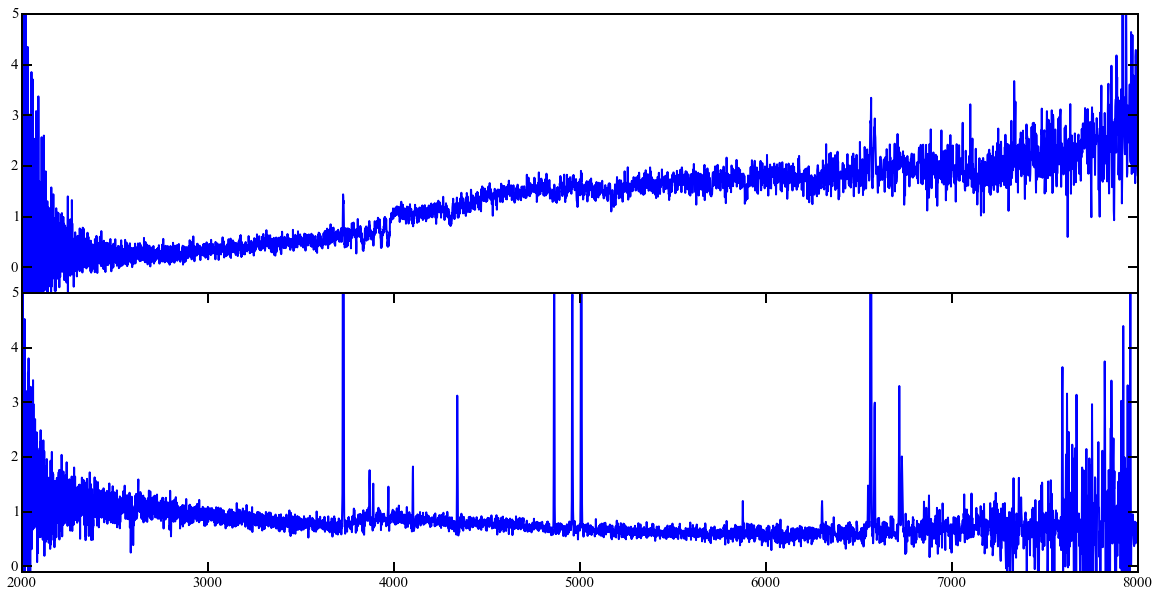

In [96]:
#i = 0
i += 1
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax.plot(masterwave, tmpmedian[isort[i],:])
ax.set_xlim(2000, 8000)
ax.set_ylim(-0.5, 5)
ax.set_xticks([])
print(i, np.count_nonzero(a_matrix[:,iarchetype[isort[i]]]))
i += 1
ax = fig.add_subplot(212)
ax.plot(masterwave, tmpmedian[isort[i],:])
print(i, np.count_nonzero(a_matrix[:,iarchetype[isort[i]]]))
ax.set_xlim(2000, 8000)
ax.set_ylim(-0.1, 5)